In [9]:
import random
from pathlib import Path
import tarfile
from typing import Any
from logging import INFO, DEBUG
from collections import defaultdict, OrderedDict
from collections.abc import Sequence, Callable
import numbers

import numpy as np
import torch
from torch import nn
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset
from enum import IntEnum
import flwr
from flwr.server import History, ServerConfig
from flwr.server.strategy import FedAvgM as FedAvg, Strategy
from flwr.common import log, NDArrays, Scalar, Parameters, ndarrays_to_parameters
from flwr.client.client import Client

import matplotlib.pyplot as plt


from common.client_utils import (
    Net,
    load_femnist_dataset,
    get_network_generator_cnn as get_network_generator,
    train_femnist,
    test_femnist,
    save_history,
)


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    """Seeds for reproducibility."""

    DEFAULT = 1337


np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


PathType = Path | str | None


def get_device() -> str:
    """Get the device (cuda, mps, cpu)."""
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = "mps"
    return device

In [10]:
home_dir = Path.cwd()
dataset_dir: Path = home_dir / "femnist"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / "client_data_mappings" / "centralized"
centralized_mapping: Path = dataset_dir / "client_data_mappings" / "centralized" / "0"
federated_partition: Path = dataset_dir / "client_data_mappings" / "fed_natural"

# Decompress dataset
if not dataset_dir.exists():
    with tarfile.open(home_dir / "femnist.tar.gz", "r:gz") as tar:
        tar.extractall(path=home_dir)
    log(INFO, "Dataset extracted in %s", dataset_dir)

In [11]:
def set_model_parameters(net: Module, parameters: NDArrays) -> Module:
    """Put a set of parameters into the model object."""
    weights = parameters
    params_dict = zip(net.state_dict().keys(), weights, strict=False)
    state_dict = OrderedDict({k: torch.from_numpy(np.copy(v)) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)
    return net


def get_model_parameters(net: Module) -> NDArrays:
    """Get the current model parameters as NDArrays."""
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [12]:
def compute_noise_scale_from_gradients(grad_list, eps=1e-6):
    """
    Compute the noise scale (Bsimple) from a list of gradient vectors.
    
    Parameters:
        grad_list (list[Tensor]): List of gradient vectors.
        eps (float): Small constant for numerical stability.
    
    Returns:
        float: Estimated noise scale.
    """
    try:
        if not grad_list:
            return None

        # Stack gradients: shape (num_batches, num_params)
        grad_stack = torch.stack(grad_list)
        mean_grad = grad_stack.mean(dim=0)
        # Compute average variance per parameter element.
        var_grad = grad_stack.var(dim=0, unbiased=False).mean()
        denom = mean_grad.norm()**2 + eps
        noise_scale = var_grad / denom
        log(DEBUG, "good")
        return noise_scale.item()
    except Exception as e:
        log(DEBUG, "Error in compute_noise_scale_from_gradients: %s", e)
        return None
    finally:
        log(DEBUG, "Exiting compute_noise_scale_from_gradients")

def get_gradient_vector(model, data, target, loss_fn, device):
    model.zero_grad()
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = loss_fn(output, target)
    loss.backward()
    
    grads = []
    for p in model.parameters():
        if p.grad is not None:
            grads.append(p.grad.view(-1))
    if grads:
        return torch.cat(grads)
    log(DEBUG, "No gradients found")
    return None

def collect_gradients(model, train_loader, device, criterion, num_mini_batches):
    grad_vectors = []
    for i, (data, target) in enumerate(train_loader):
        if i >= num_mini_batches:
            break
        grad_vector = get_gradient_vector(model, data, target, criterion, device)
        if grad_vector is not None:
            grad_vectors.append(grad_vector)
    return grad_vectors

In [13]:
class FlowerRayClient(flwr.client.NumPyClient):
    """Flower client for the FEMNIST dataset."""

    def __init__(
        self,
        cid: int,
        partition_dir: Path,
        model_generator: Callable[[], Module],
    ) -> None:
        """Init the client with its unique id and the folder to load data from.

        Parameters:
            cid (int): Unique client id for a client used to map it to its data
                partition
            partition_dir (Path): The directory containing data for each
                client/client id
            model_generator (Callable[[], Module]): The model generator function
        
        """
        self.cid = cid
        log(INFO, "cid: %s", self.cid)
        self.partition_dir = partition_dir
        self.device = str(
            torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        )
        self.model_generator: Callable[[], Module] = model_generator
        self.properties: dict[str, Scalar] = {"tensor_type": "numpy.ndarray"}

    def set_parameters(self, parameters: NDArrays) -> Module:
        """Load weights inside the network."""
        net = self.model_generator()
        return set_model_parameters(net, parameters)

    def get_parameters(self, config: dict[str, Scalar]) -> NDArrays:
        """Return weights from a given model.

        If no model is passed, then a local model is created.
        This can be used to initialise a model in the
        server.
        The config param is not used but is mandatory in Flower.

        """
        net = self.model_generator()
        return get_model_parameters(net)

    def fit(self, parameters: NDArrays, config: dict[str, Scalar]) -> tuple[NDArrays, int, dict]:
        """Receive and train a model on the local client data."""
        # Only create model right before training/testing
        # To lower memory usage when idle
        net = self.set_parameters(parameters)
        net.to(self.device)

        train_loader: DataLoader = self._create_data_loader(config, name="train")
        train_loss = self._train(net, train_loader=train_loader, config=config)

        # Compute gradients
        # Collect gradients for noise scale estimation.
        grad_vectors = collect_gradients(net, train_loader, self.device, torch.nn.CrossEntropyLoss(), 5)
        # Compute local noise scale (Bsimple) on this client.
        local_noise_scale = compute_noise_scale_from_gradients(grad_vectors)

        return get_model_parameters(net), len(train_loader), {"train_loss": train_loss, "noise_scale": local_noise_scale}

    def evaluate(self, parameters: NDArrays, config: dict[str, Scalar]) -> tuple[float, int, dict]:
        """Receive and test a model on the local client data."""
        net = self.set_parameters(parameters)
        net.to(self.device)

        test_loader: DataLoader = self._create_data_loader(config, name="test")
        loss, accuracy = self._test(net, test_loader=test_loader, config=config)
        return loss, len(test_loader), {"local_accuracy": accuracy}

    def _create_data_loader(self, config: dict[str, Scalar], name: str) -> DataLoader:
        """Create the data loader using the specified config parameters."""
        batch_size = int(config["batch_size"])
        num_workers = int(config["num_workers"])
        dataset = self._load_dataset(name)
        return DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            drop_last=(name == "train"),
        )

    def _load_dataset(self, name: str) -> Dataset:
        full_file: Path = self.partition_dir / str(self.cid)
        return load_femnist_dataset(
            mapping=full_file,
            name=name,
            data_dir=data_dir,
        )

    def _train(
        self, net: Module, train_loader: DataLoader, config: dict[str, Scalar]
    ) -> float:
        return train_femnist(
            net=net,
            train_loader=train_loader,
            epochs=int(config["epochs"]),
            device=self.device,
            optimizer=torch.optim.AdamW(
                net.parameters(),
                lr=float(config["client_learning_rate"]),
                weight_decay=float(config["weight_decay"]),
            ),
            criterion=torch.nn.CrossEntropyLoss(),
            max_batches=int(config["max_batches"]),
        )

    def _test(
        self, net: Module, test_loader: DataLoader, config: dict[str, Scalar]
    ) -> tuple[float, float]:
        return test_femnist(
            net=net,
            test_loader=test_loader,
            device=self.device,
            criterion=torch.nn.CrossEntropyLoss(),
            max_batches=int(config["max_batches"]),
        )

    def get_properties(self, config: dict[str, Scalar]) -> dict[str, Scalar]:
        """Return properties for this client."""
        return self.properties

    def get_train_set_size(self) -> int:
        """Return the client train set size."""
        return len(self._load_dataset("train"))  # type: ignore[reportArgumentType]

    def get_test_set_size(self) -> int:
        """Return the client test set size."""
        return len(self._load_dataset("test"))  # type: ignore[reportArgumentType]


def fit_client_seeded(
    client: FlowerRayClient,
    params: NDArrays,
    conf: dict[str, Any],
    seed: Seeds = Seeds.DEFAULT,
    **kwargs: Any,
) -> tuple[NDArrays, int, dict]:
    """Wrap to always seed client training."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return client.fit(params, conf, **kwargs)

In [14]:
def get_flower_client_generator(
    model_generator: Callable[[], Module],
    partition_dir: Path,
    mapping_fn: Callable[[int], int] | None = None,
) -> Callable[[str], FlowerRayClient]:
    """Wrap the client instance generator.

    A mapping function could be used for filtering/ordering clients.

    Parameters
    ----------
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered
            ids to real cid.
    """

    def client_fn(cid: str) -> FlowerRayClient:
        """Create a single client instance given the client id `cid`."""
        return FlowerRayClient(
            cid=mapping_fn(int(cid)) if mapping_fn is not None else int(cid),
            partition_dir=partition_dir,
            model_generator=model_generator,
        )

    return client_fn

## Centralized Baseline (1 FL client only)

In [15]:
network_generator = get_network_generator()
seed_net: Net = network_generator()
seed_model_params: NDArrays = get_model_parameters(seed_net)

centralized_flower_client_generator: Callable[[str], FlowerRayClient] = (
    get_flower_client_generator(network_generator, centralized_partition)
)
centralized_flower_client = centralized_flower_client_generator(str(0))

INFO flwr 2025-02-23 15:29:05,812 | 3950532377.py:21 | cid: 0


In [16]:
centralized_train_config: dict[str, Any] = {
    "epochs": 4,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

# Train parameters on the centralised dataset
trained_params, num_examples, train_metrics = fit_client_seeded(
    centralized_flower_client, params=seed_model_params, conf=centralized_train_config
)
log(INFO, "Train Metrics = %s", train_metrics)

DEBUG flwr 2025-02-23 15:29:15,717 | 1925459797.py:23 | good
DEBUG flwr 2025-02-23 15:29:15,719 | 1925459797.py:29 | Exiting compute_noise_scale_from_gradients
INFO flwr 2025-02-23 15:29:15,754 | 2944962118.py:20 | Train Metrics = {'train_loss': 0.07441831767559051, 'noise_scale': 4.87755132780876e-05}


In [17]:
# Test trained parameters on the centralised dataset
loss, num_examples, test_metrics = centralized_flower_client.evaluate(
    parameters=trained_params, config=test_config
)
log(INFO, "Loss = %s; Test Metrics = %s", loss, test_metrics)

  4%|▍         | 100/2329 [00:02<00:48, 45.84it/s]
INFO flwr 2025-02-23 15:29:18,584 | 592755603.py:5 | Loss = 224.33516204357147; Test Metrics = {'local_accuracy': 0.3940625}


## Federated setting with natural partitions

In [18]:
def sample_random_clients(
    total_clients: int,
    filter_less: int,
    partition: Path,
    seed: int | None = Seeds.DEFAULT,
) -> Sequence[int]:
    """Sample randomly clients.

    A filter on the client train set size is performed.

    Parameters
    ----------
        total_clients (int): total number of clients to sample.
        filter_less (int): max number of train samples for which the client is
            **discarded**.
        partition (Path): path to the folder containing the partitioning.
    """
    real_federated_cid_client_generator: Callable[[str], FlowerRayClient] = (
        get_flower_client_generator(network_generator, federated_partition)
    )
    if seed is not None:
        random.seed(seed)
    list_of_ids = []
    while len(list_of_ids) < total_clients:
        current_id = random.randint(0, 3229)
        if (
            real_federated_cid_client_generator(str(current_id)).get_train_set_size()
            > filter_less
        ):
            list_of_ids.append(current_id)
    return list_of_ids

While FEMNIST has more than 3000 clients, we will limit our experiments to 100 (for now).

In [19]:
total_clients: int = 100
list_of_ids = sample_random_clients(
    total_clients, centralized_train_config["batch_size"], federated_partition
)

federated_client_generator: Callable[[str], FlowerRayClient] = (
    get_flower_client_generator(
        network_generator, federated_partition, lambda seq_id: list_of_ids[seq_id]
    )
)

INFO flwr 2025-02-23 15:29:18,602 | 3950532377.py:21 | cid: 2530
INFO flwr 2025-02-23 15:29:18,605 | 3950532377.py:21 | cid: 2184
INFO flwr 2025-02-23 15:29:18,608 | 3950532377.py:21 | cid: 2907
INFO flwr 2025-02-23 15:29:18,610 | 3950532377.py:21 | cid: 1498
INFO flwr 2025-02-23 15:29:18,613 | 3950532377.py:21 | cid: 2338
INFO flwr 2025-02-23 15:29:18,616 | 3950532377.py:21 | cid: 2399
INFO flwr 2025-02-23 15:29:18,618 | 3950532377.py:21 | cid: 2997
INFO flwr 2025-02-23 15:29:18,621 | 3950532377.py:21 | cid: 678
INFO flwr 2025-02-23 15:29:18,624 | 3950532377.py:21 | cid: 3175
INFO flwr 2025-02-23 15:29:18,626 | 3950532377.py:21 | cid: 1363
INFO flwr 2025-02-23 15:29:18,629 | 3950532377.py:21 | cid: 1571
INFO flwr 2025-02-23 15:29:18,631 | 3950532377.py:21 | cid: 2600
INFO flwr 2025-02-23 15:29:18,634 | 3950532377.py:21 | cid: 1473
INFO flwr 2025-02-23 15:29:18,636 | 3950532377.py:21 | cid: 1260
INFO flwr 2025-02-23 15:29:18,640 | 3950532377.py:21 | cid: 1603
INFO flwr 2025-02-23 15:29

**Real training FL**

In [20]:
def get_federated_evaluation_function(
    batch_size: int,
    num_workers: int,
    model_generator: Callable[[], Module],
    criterion: Module,
    max_batches: int,
) -> Callable[[int, NDArrays, dict[str, Any]], tuple[float, dict[str, Scalar]]]:
    """Wrap the external federated evaluation function.

    It provides the external federated evaluation function with some
    parameters for the dataloader, the model generator function, and
    the criterion used in the evaluation.

    Parameters
    ----------
        batch_size (int): batch size of the test set to use.
        num_workers (int): correspond to `num_workers` param in the Dataloader object.
        model_generator (Callable[[], Module]):  model generator function.
        criterion (Module): PyTorch Module containing the criterion for evaluating the
        model.

    Returns
    ----------
        External federated evaluation function.
    """

    def federated_evaluation_function(
        server_round: int,
        parameters: NDArrays,
        fed_eval_config: dict[
            str, Any
        ],  # mandatory argument, even if it's not being used
    ) -> tuple[float, dict[str, Scalar]]:
        """Evaluate federated model on the server.

        It uses the centralized val set for sake of simplicity.

        Parameters
        ----------
            server_round (int): current federated round.
            parameters (NDArrays): current model parameters.
            fed_eval_config (dict[str, Any]): mandatory argument in Flower, can contain
                some configuration info

        Returns
        -------
            tuple[float, dict[str, Scalar]]: evaluation results
        """
        device: str = get_device()
        net: Module = set_model_parameters(model_generator(), parameters)
        net.to(device)

        full_file: Path = centralized_mapping
        dataset: Dataset = load_femnist_dataset(data_dir, full_file, "val")

        valid_loader = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            drop_last=False,
        )

        loss, acc = test_femnist(
            net=net,
            test_loader=valid_loader,
            device=device,
            criterion=criterion,
            max_batches=max_batches,
        )
        return loss, {"accuracy": acc}

    return federated_evaluation_function

In [21]:
def aggregate_weighted_average(metrics: list[tuple[int, dict]]) -> dict:
    """Combine results from multiple clients following training or evaluation.

    Parameters
    ----------
        metrics (list[tuple[int, dict]]): collected clients metrics

    Returns
    -------
        dict: result dictionary containing the aggregate of the metrics passed.
    """
    average_dict: dict = defaultdict(list)
    total_examples: int = 0
    for num_examples, metrics_dict in metrics:
        for key, val in metrics_dict.items():
            if isinstance(val, numbers.Number):
                average_dict[key].append((num_examples, val))
        total_examples += num_examples
    return {
        key: {
            "avg": float(
                sum([num_examples * metric for num_examples, metric in val])
                / float(total_examples)
            ),
            "all": val,
        }
        for key, val in average_dict.items()
    }

In [22]:
def start_seeded_simulation(
    client_fn: Callable[[str], Client],
    num_clients: int,
    config: ServerConfig,
    strategy: Strategy,
    name: str,
    return_all_parameters: bool = False,
    seed: int = Seeds.DEFAULT,
    iteration: int = 0,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Wrap to seed client selection."""
    np.random.seed(seed ^ iteration)
    torch.manual_seed(seed ^ iteration)
    random.seed(seed ^ iteration)
    parameter_list, hist = flwr.simulation.start_simulation_no_ray(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources={},
        config=config,
        strategy=strategy,
    )
    save_history(home_dir, hist, name)
    return parameter_list, hist

def run_simulation(
    num_rounds: int,
    num_total_clients: int,
    num_clients_per_round: int,
    num_evaluate_clients: int,
    min_available_clients: int,
    min_fit_clients: int,
    min_evaluate_clients: int,
    evaluate_fn: (Callable[[int, NDArrays, dict[str, Scalar]], tuple[float, dict[str, Scalar]] | None] | None),
    on_fit_config_fn: Callable[[int], dict[str, Scalar]],
    on_evaluate_config_fn: Callable[[int], dict[str, Scalar]],
    initial_parameters: Parameters,
    fit_metrics_aggregation_fn: Callable | None,
    evaluate_metrics_aggregation_fn: Callable | None,
    federated_client_generator: Callable[
        [str], flwr.client.NumPyClient
    ] = federated_client_generator,
    server_learning_rate: float = 1.0,
    server_momentum: float = 0.0,
    accept_failures: bool = False,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Run a federated simulation using Flower."""
    log(INFO, "FL will execute for %s rounds", num_rounds)

    # Percentage of clients used for train/eval
    fraction_fit: float = float(num_clients_per_round) / num_total_clients
    fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients

    strategy = FedAvg(
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=min_fit_clients,
        min_evaluate_clients=min_evaluate_clients,
        min_available_clients=min_available_clients,
        on_fit_config_fn=on_fit_config_fn,
        on_evaluate_config_fn=on_evaluate_config_fn,
        evaluate_fn=evaluate_fn,
        initial_parameters=initial_parameters,
        accept_failures=accept_failures,
        fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
        evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
    )
    # resetting the seed for the random selection of clients
    # this way the list of clients trained is guaranteed to be always the same

    cfg = ServerConfig(num_rounds)

    def simulator_client_generator(cid: str) -> Client:
        return federated_client_generator(cid).to_client()

    parameters_for_each_round, hist = start_seeded_simulation(
        client_fn=simulator_client_generator,
        num_clients=num_total_clients,
        config=cfg,
        strategy=strategy,
        name="fedavg",
        return_all_parameters=True,
        seed=Seeds.DEFAULT,
    )
    return parameters_for_each_round, hist

**FL RUN**

In [23]:
# Federated configuration dictionary
federated_train_config = {
    "epochs": 5,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

federated_test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

num_rounds = 10
num_total_clients = 20
num_evaluate_clients = 0
num_clients_per_round = 5

initial_parameters = ndarrays_to_parameters(seed_model_params)

federated_evaluation_function = get_federated_evaluation_function(
    batch_size=federated_test_config["batch_size"],
    num_workers=federated_test_config["num_workers"],
    model_generator=network_generator,
    criterion=nn.CrossEntropyLoss(),
    max_batches=federated_test_config["max_batches"],
)

server_learning_rate = 1.0
server_momentum = 0.0
accept_failures = False

In [24]:
parameters_for_each_round, hist = run_simulation(
    num_rounds = num_rounds,
    num_total_clients = num_total_clients,
    num_clients_per_round = num_clients_per_round,
    num_evaluate_clients = num_evaluate_clients,
    min_available_clients = num_total_clients,
    min_fit_clients = num_clients_per_round,
    min_evaluate_clients = num_evaluate_clients,
    evaluate_fn = federated_evaluation_function,
    on_fit_config_fn = lambda _: federated_train_config,
    on_evaluate_config_fn = lambda _: federated_test_config,
    initial_parameters = initial_parameters,
    fit_metrics_aggregation_fn = aggregate_weighted_average,
    evaluate_metrics_aggregation_fn = aggregate_weighted_average,
    federated_client_generator = federated_client_generator,
    server_learning_rate=server_learning_rate,
    server_momentum=server_momentum,
    accept_failures=accept_failures,
    )

INFO flwr 2025-02-23 15:29:18,950 | 2786322904.py:47 | FL will execute for 10 rounds
INFO flwr 2025-02-23 15:29:18,953 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flwr 2025-02-23 15:29:18,954 | server_returns_parameters.py:81 | Initializing global parameters
INFO flwr 2025-02-23 15:29:18,955 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-02-23 15:29:18,957 | server_returns_parameters.py:84 | Evaluating initial parameters
 11%|█         | 100/891 [00:02<00:17, 46.03it/s]
INFO flwr 2025-02-23 15:29:21,393 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.6843070983887, {'accuracy': 0.0065625}
INFO flwr 2025-02-23 15:29:21,393 | server_returns_parameters.py:97 | FL starting
DEBUG flwr 2025-02-23 15:29:21,394 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 20)
INFO flwr 2025-02-23 15:29:21,396 | 3950532377.py:21 

**Centralized Run**

In [25]:
network_generator = get_network_generator()
seed_net: Net = network_generator()
seed_model_params: NDArrays = get_model_parameters(seed_net)

centralized_flower_client_generator: Callable[[str], FlowerRayClient] = (
    get_flower_client_generator(network_generator, centralized_partition)
)
centralized_flower_client = centralized_flower_client_generator(str(0))

centralized_train_config: dict[str, Any] = {
    "epochs": 50, # we have 5 epochs * 10 rounds in FL
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

# Train parameters on the centralised dataset
trained_params, num_examples, train_metrics = fit_client_seeded(
    centralized_flower_client, params=seed_model_params, conf=centralized_train_config
)
log(INFO, "Train Metrics = %s", train_metrics)

# Test trained parameters on the centralised dataset
loss, num_examples, test_metrics = centralized_flower_client.evaluate(
    parameters=trained_params, config=test_config
)
log(INFO, "Loss = %s; Test Metrics = %s", loss, test_metrics)

INFO flwr 2025-02-23 15:30:01,312 | 3950532377.py:21 | cid: 0
DEBUG flwr 2025-02-23 15:32:01,617 | 1925459797.py:23 | good
DEBUG flwr 2025-02-23 15:32:01,619 | 1925459797.py:29 | Exiting compute_noise_scale_from_gradients
INFO flwr 2025-02-23 15:32:01,692 | 1992986476.py:29 | Train Metrics = {'train_loss': 0.02927033103071153, 'noise_scale': 0.00016448486712761223}
  4%|▍         | 100/2329 [00:02<00:47, 47.20it/s]
INFO flwr 2025-02-23 15:32:04,441 | 1992986476.py:35 | Loss = 91.70192721486092; Test Metrics = {'local_accuracy': 0.7246875}


**Centralized run with varying batch sizes**

In [26]:
def centralized_experiment(centralized_train_cfg, centralized_test_cfg, train_loader, test_loader, device):
    model = network_generator().to(device)
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=centralized_train_cfg["client_learning_rate"],
        weight_decay=centralized_train_cfg["weight_decay"]
        )
    criterion = nn.CrossEntropyLoss()

    epoch_accuracies = []
    epoch_losses = []
    epoch_noise_scales = []

    for epoch in range(centralized_train_cfg["epochs"]):
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            if batch_idx >= centralized_train_cfg["max_batches"]:
                break
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * data.size(0)
        running_loss /= len(train_loader.dataset)
        epoch_losses.append(running_loss)

        # collect gradients over a few mini-batches
        grad_vectors = collect_gradients(model, train_loader, device, criterion, 5) 
        noise_scale = compute_noise_scale_from_gradients(grad_vectors)
        epoch_noise_scales.append(noise_scale)

        # Evaluate the trained model
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                if batch_idx >= centralized_test_cfg["max_batches"]:
                    break
                data, target = data.to(device), target.to(device)
                output = model(data)
                preds = output.argmax(dim=1)
                correct += (preds == target).sum().item()
                total += target.size(0)
        accuracy = correct / total
        epoch_accuracies.append(accuracy)

        log(INFO, f"Epoch {epoch+1}/{centralized_train_cfg['epochs']}, Loss: {running_loss:.4f}, "
              f"Noise scale: {noise_scale:.4e}, Accuracy: {accuracy*100:.2f}%")
    
    return {
        "accuracies": epoch_accuracies,
        "losses": epoch_losses,
        "noise_scales": epoch_noise_scales,
    }


In [27]:
# Load the centralized dataset using the same function as in FL.
# The centralized mapping folder should be the one used in your FL centralized experiment.
centralized_train_dataset = load_femnist_dataset(data_dir=data_dir,mapping=centralized_mapping, name="train")
centralized_test_dataset = load_femnist_dataset(data_dir=data_dir, mapping=centralized_mapping, name="test")

# Use the same configuration parameters as in your FL config.
centralized_train_config: dict[str, Any] = {
    "epochs": 50, # we have 5 epochs * 10 rounds in FL
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

centralized_test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}


In [28]:
no_fl_batch_sizes = [8, 16, 32, 64, 128]

total_baseline_results = []

for batch_size in no_fl_batch_sizes:

    train_cfg = centralized_train_config.copy()
    train_cfg["batch_size"] = batch_size

    test_cfg = centralized_test_config.copy()
    test_cfg["batch_size"] = batch_size

    # Create DataLoaders with the same settings.
    centralized_train_loader = DataLoader(
        dataset=centralized_train_dataset,
        batch_size=train_cfg["batch_size"],
        shuffle=True,                # Shuffle for training
        num_workers=train_cfg["num_workers"],
        drop_last=True,              # If FL training drops last batch, do the same here.
    )

    centralized_test_loader = DataLoader(
        dataset=centralized_test_dataset,
        batch_size=test_cfg["batch_size"],
        shuffle=False,               # No shuffling during evaluation
        num_workers=test_cfg["num_workers"],
        drop_last=False,
    )

    no_fl_results = centralized_experiment(centralized_train_config, centralized_test_config, centralized_train_loader, centralized_test_loader, get_device())

    total_baseline_results.append((batch_size, no_fl_results))


DEBUG flwr 2025-02-23 15:32:09,022 | 1925459797.py:23 | good
DEBUG flwr 2025-02-23 15:32:09,024 | 1925459797.py:29 | Exiting compute_noise_scale_from_gradients
INFO flwr 2025-02-23 15:32:09,554 | 644884091.py:51 | Epoch 1/50, Loss: 0.0048, Noise scale: 9.8295e-05, Accuracy: 3.38%
DEBUG flwr 2025-02-23 15:32:10,178 | 1925459797.py:23 | good
DEBUG flwr 2025-02-23 15:32:10,180 | 1925459797.py:29 | Exiting compute_noise_scale_from_gradients
INFO flwr 2025-02-23 15:32:10,685 | 644884091.py:51 | Epoch 2/50, Loss: 0.0046, Noise scale: 9.5718e-05, Accuracy: 2.12%
DEBUG flwr 2025-02-23 15:32:11,261 | 1925459797.py:23 | good
DEBUG flwr 2025-02-23 15:32:11,262 | 1925459797.py:29 | Exiting compute_noise_scale_from_gradients
INFO flwr 2025-02-23 15:32:11,671 | 644884091.py:51 | Epoch 3/50, Loss: 0.0045, Noise scale: 8.9992e-05, Accuracy: 4.12%
DEBUG flwr 2025-02-23 15:32:12,654 | 1925459797.py:23 | good
DEBUG flwr 2025-02-23 15:32:12,656 | 1925459797.py:29 | Exiting compute_noise_scale_from_gradien

In [29]:
def compute_critical_batch(noise_scales: list, constant: float = 1.0) -> float:
    # simple avg of noise scales
    avg_noise_scale = np.mean(noise_scales)
    eps = 1e-8
    
    # Computing an estimated critical batch size (Bcrit) using a simple heuristic.
    critical_batch_size = constant / (avg_noise_scale + eps)
    return critical_batch_size

INFO flwr 2025-02-23 16:30:32,535 | 2505006679.py:14 | Batch size: 8
INFO flwr 2025-02-23 16:30:32,536 | 2505006679.py:15 | Accuracies: [0.03375, 0.02125, 0.04125, 0.03125, 0.065, 0.08875, 0.09125, 0.125, 0.17875, 0.16125, 0.165, 0.15625, 0.19125, 0.25625, 0.2125, 0.23625, 0.2225, 0.22125, 0.30625, 0.24125, 0.31875, 0.27875, 0.2875, 0.31, 0.26875, 0.2575, 0.32, 0.25375, 0.27875, 0.3125, 0.37625, 0.36, 0.3675, 0.3875, 0.405, 0.37125, 0.3625, 0.37, 0.3675, 0.33, 0.28125, 0.3975, 0.4025, 0.4075, 0.42375, 0.37125, 0.38, 0.40375, 0.4325, 0.35625]
INFO flwr 2025-02-23 16:30:32,537 | 2505006679.py:16 | Losses: [0.004775145348607835, 0.004635199519257062, 0.004474636429513315, 0.004340499075065496, 0.004280190220637187, 0.00401947053156804, 0.003917649851365357, 0.0037847492745678828, 0.0037690265174857174, 0.003628150192439015, 0.0035841820971648547, 0.003419536772899301, 0.0034471667956254295, 0.0033427479724537196, 0.0033484299923494678, 0.003236777375921252, 0.0032215597421217054, 0.003114

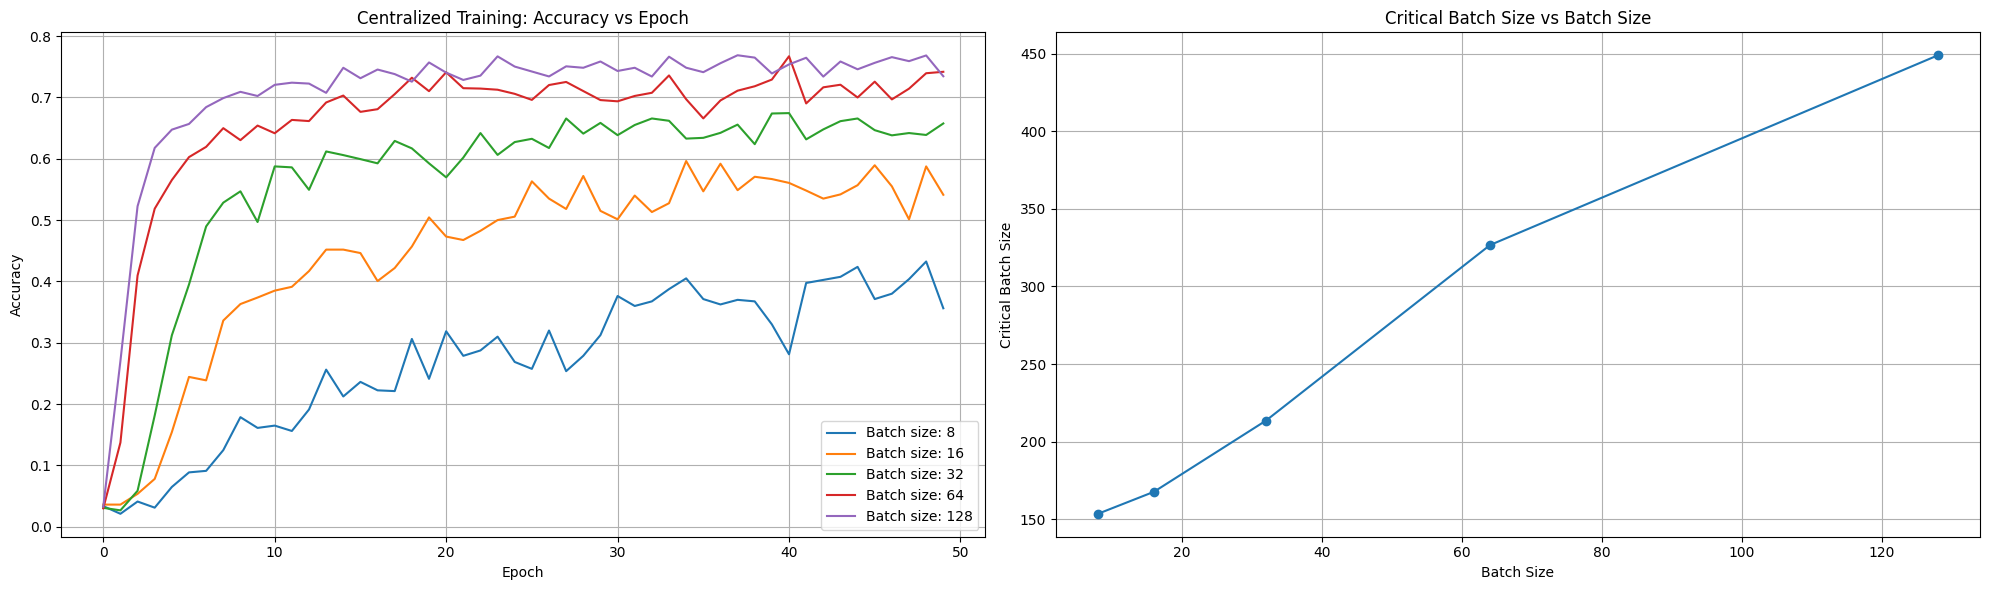

In [43]:
import matplotlib.pyplot as plt

critical_batches_no_fl = []

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Left subplot: Accuracy vs Epoch for each batch size configuration
for batch_size, results in total_baseline_results:
    axes[0].plot(results["accuracies"], label=f"Batch size: {batch_size}")
    bcrit = compute_critical_batch(results["noise_scales"], constant=0.01)
    critical_batches_no_fl.append((batch_size, bcrit))
    # Logging information (optional)
    log(INFO, f"Batch size: {batch_size}")
    log(INFO, f"Accuracies: {results['accuracies']}")
    log(INFO, f"Losses: {results['losses']}")
    log(INFO, f"Noise scales: {results['noise_scales']}")
    log(INFO, f"Critical batch size: {bcrit}")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Centralized Training: Accuracy vs Epoch")
axes[0].legend()
axes[0].grid(True)

# Right subplot: Critical Batch Size vs Batch Size
batch_sizes = [bs for bs, _ in critical_batches_no_fl]
bcrit_values = [bcrit for _, bcrit in critical_batches_no_fl]

axes[1].plot(batch_sizes, bcrit_values, marker='o')
axes[1].set_xlabel("Batch Size")
axes[1].set_ylabel("Critical Batch Size")
axes[1].set_title("Critical Batch Size vs Batch Size")
axes[1].grid(True)

plt.tight_layout()
plt.show()


We can also observe that increasing batch size appears does in fact alter performance.

Furthermore, both $\beta_{\text{simple}}$ computation and the empirical results seem to indicate optimal batch sizes with magnitudes in the hundreds (100-1000).

**FL run with varying batch sizes**

In [31]:
# Federated configuration dictionary
federated_train_config = {
    "epochs": 10,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

federated_test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

num_rounds = 10
num_total_clients = 100
num_evaluate_clients = 0
num_clients_per_round = 10

initial_parameters = ndarrays_to_parameters(seed_model_params)

federated_evaluation_function = get_federated_evaluation_function(
    batch_size=federated_test_config["batch_size"],
    num_workers=federated_test_config["num_workers"],
    model_generator=network_generator,
    criterion=nn.CrossEntropyLoss(),
    max_batches=federated_test_config["max_batches"],
)

server_learning_rate = 1.0
server_momentum = 0.0
accept_failures = False

In [32]:
batch_sizes = [8, 16, 32, 64, 128]
total_results = []

for batch_size in batch_sizes:
    train_cfg = federated_train_config.copy()
    train_cfg["batch_size"] = batch_size

    test_cfg = federated_test_config.copy()
    test_cfg["batch_size"] = batch_size

    parameters_for_each_round, hist = run_simulation(
        num_rounds = num_rounds,
        num_total_clients = num_total_clients,
        num_clients_per_round = num_clients_per_round,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = num_clients_per_round,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        )

    total_results.append((batch_size, parameters_for_each_round, hist))

INFO flwr 2025-02-23 15:56:22,894 | 2786322904.py:47 | FL will execute for 10 rounds
INFO flwr 2025-02-23 15:56:22,895 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flwr 2025-02-23 15:56:22,897 | server_returns_parameters.py:81 | Initializing global parameters
INFO flwr 2025-02-23 15:56:22,897 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-02-23 15:56:22,901 | server_returns_parameters.py:84 | Evaluating initial parameters
 11%|█         | 100/891 [00:01<00:11, 67.40it/s]
INFO flwr 2025-02-23 15:56:24,543 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 414.5207839012146, {'accuracy': 0.0034375}
INFO flwr 2025-02-23 15:56:24,544 | server_returns_parameters.py:97 | FL starting
DEBUG flwr 2025-02-23 15:56:24,545 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 10 clients (out of 100)
INFO flwr 2025-02-23 15:56:24,545 | 3950532377.py:2

In [33]:
def get_centralized_acc_from_hist(hist):
    accuracies = [val for r, val in hist.metrics_centralized['accuracy']]
    return accuracies

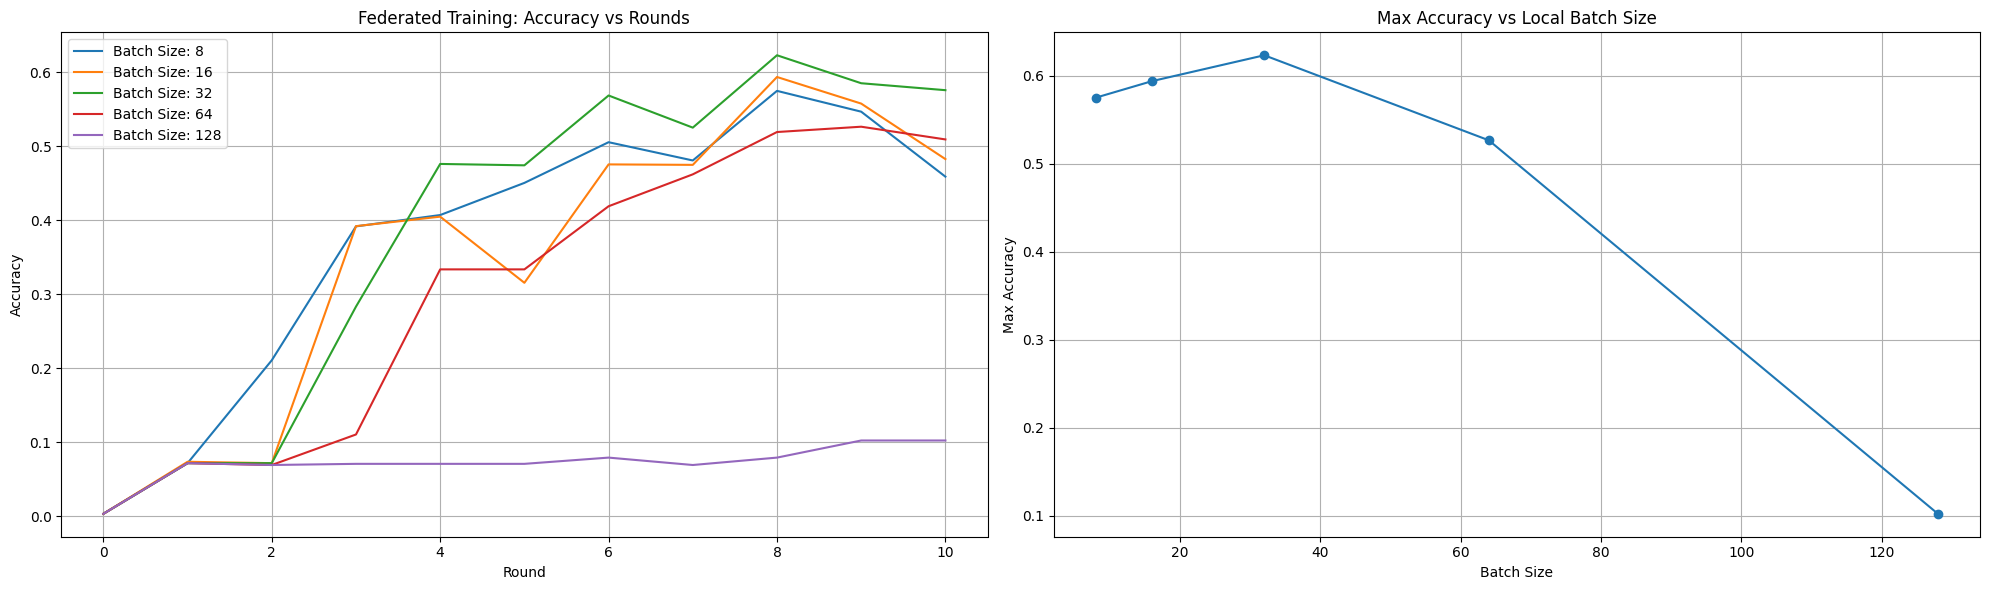

In [44]:
import matplotlib.pyplot as plt

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Left subplot: Accuracy vs Rounds for each batch size
for batch_size, params, hist in total_results:
    accuracies = get_centralized_acc_from_hist(hist)
    axes[0].plot(accuracies, label=f"Batch Size: {batch_size}")
axes[0].set_xlabel("Round")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Federated Training: Accuracy vs Rounds")
axes[0].legend()
axes[0].grid(True)

# Right subplot: Max Accuracy vs Batch Size
batch_sizes = []
max_accuracies = []
for batch_size, params, hist in total_results:
    accuracies = get_centralized_acc_from_hist(hist)
    if accuracies:
        batch_sizes.append(batch_size)
        max_accuracies.append(max(accuracies))
axes[1].plot(batch_sizes, max_accuracies, marker='o')
axes[1].set_xlabel("Batch Size")
axes[1].set_ylabel("Max Accuracy")
axes[1].set_title("Max Accuracy vs Local Batch Size")
axes[1].grid(True)

plt.tight_layout()
plt.show()


When running FL experiments with multiple batch sizes, we do observe that there must be something as "critical" batch size.

However, we must investigate how to identify it.

**Running FL with varying cohort sizes**

In [35]:
cohort_sizes = [5, 10, 20, 50, 75]
total_cohort_results = []

for cohort_size in cohort_sizes:

    parameters_for_each_round, hist = run_simulation(
        num_rounds = num_rounds,
        num_total_clients = num_total_clients,
        num_clients_per_round = cohort_size,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = cohort_size,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        )

    total_cohort_results.append((cohort_size, parameters_for_each_round, hist))

INFO flwr 2025-02-23 16:04:16,595 | 2786322904.py:47 | FL will execute for 10 rounds
INFO flwr 2025-02-23 16:04:16,600 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flwr 2025-02-23 16:04:16,601 | server_returns_parameters.py:81 | Initializing global parameters
INFO flwr 2025-02-23 16:04:16,601 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-02-23 16:04:16,603 | server_returns_parameters.py:84 | Evaluating initial parameters
 11%|█         | 100/891 [00:00<00:04, 166.20it/s]
INFO flwr 2025-02-23 16:04:17,464 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 414.5207839012146, {'accuracy': 0.0034375}
INFO flwr 2025-02-23 16:04:17,465 | server_returns_parameters.py:97 | FL starting
DEBUG flwr 2025-02-23 16:04:17,465 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 100)
INFO flwr 2025-02-23 16:04:17,466 | 3950532377.py:2

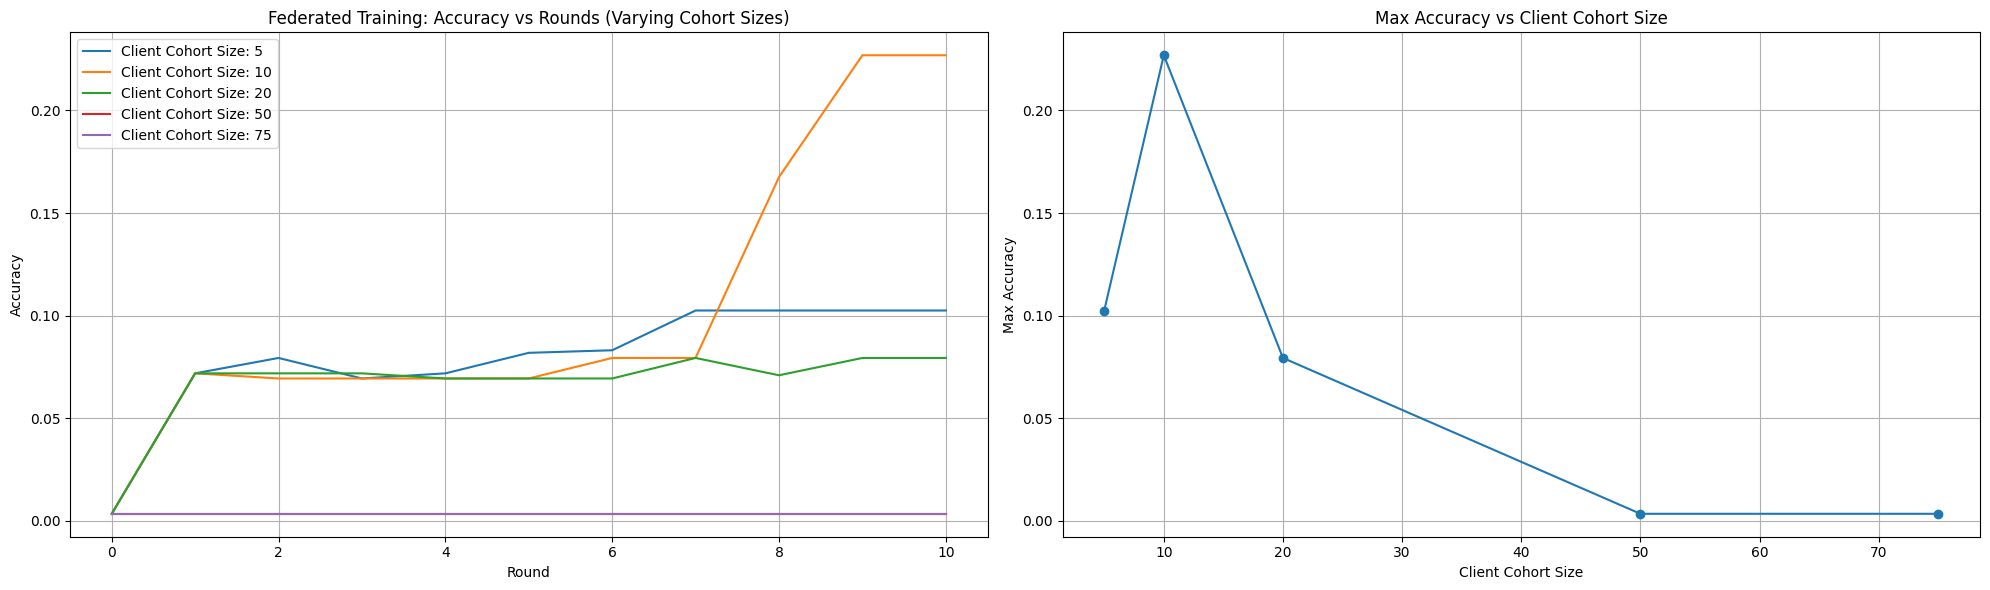

In [41]:
import matplotlib.pyplot as plt

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Left subplot: Accuracy vs Rounds for each client cohort size
for cohort_size, params, hist in total_cohort_results:
    accuracies = get_centralized_acc_from_hist(hist)
    axes[0].plot(accuracies, label=f"Client Cohort Size: {cohort_size}")
axes[0].set_xlabel("Round")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Federated Training: Accuracy vs Rounds (Varying Cohort Sizes)")
axes[0].legend()
axes[0].grid(True)

# Right subplot: Max Accuracy vs Client Cohort Size
cohort_sizes = []
max_accuracies = []
for cohort_size, params, hist in total_cohort_results:
    accuracies = get_centralized_acc_from_hist(hist)
    if accuracies:
        cohort_sizes.append(cohort_size)
        max_accuracies.append(max(accuracies))
axes[1].plot(cohort_sizes, max_accuracies, marker='o')
axes[1].set_xlabel("Client Cohort Size")
axes[1].set_ylabel("Max Accuracy")
axes[1].set_title("Max Accuracy vs Client Cohort Size")
axes[1].grid(True)

plt.tight_layout()
plt.show()


When running experiment with varying client cohort sizes, we also observe that such thing as "ideal" client cohort number exists.

However, we have to investigate how to compute it.

**$\beta_\text{simple}$ integration into Federated Learning runs**


To implement the actual $\beta_\text{simple}$ ($\beta_\text{simple} \approx \beta_\text{crit}$) computation, we would need to change the client fit fn to return the gradients after training, and we would need to aggregate them in the server somehow.

In summary, we need to somehow get them to the hist or params object, and figure out a way to aggregate them.

Done. I added the noise scale computation into the client fit fn.

Now we grab them from the hist object and compute the critical batch size with the previous formula.

In [37]:
for batch_size, params, hist in total_results:
    print("Batch size: ", batch_size)

    noise_scales = hist.metrics_distributed_fit['noise_scale']

    for round, round_noise_scales in noise_scales:
        actual_noise_scales = [val for _, val in round_noise_scales['all']]
        print(compute_critical_batch(actual_noise_scales, .001))



Batch size:  8
19.087949526705295
25.267617546608207
21.30581647404056
16.56585281669102
18.330144366133936
16.70289024962731
13.888954238705528
17.103819105799115
14.426882064991842
16.99658709356844
Batch size:  16
23.459779604969214
9.467469322269991
20.48887697824373
32.51195823814904
22.710213398840185
24.27418246209218
20.118762671971705
16.221292026748245
14.254587409206707
13.233845901431811
Batch size:  32
10.109740147944944
19.209716018622156
55.9587789073177
31.635544475426446
34.54215883752168
21.610812252534355
22.671150814250453
18.9805975248675
15.327469826009633
16.725005948304556
Batch size:  64
15.821034823237655
18.44059980948422
51.02456555582107
148.58456610555947
76.40766842755787
74.79007230675245
48.08461686112491
57.592201374428086
68.87802947728419
Batch size:  128
141.777376343993
542.6535864644403
61.946914234434715
371.8738626399483
613.3969265666008
4410.666906206309
596.1356588309367


This appears to give us a good estimate of the critical batch size. According to this estimates, the ideal batch size appears to be somewhere in the 16-64, and the optimal batch size we observe is actually 32, which is right in the middle of the range.

In [38]:
for cohort_size, params, hist in total_cohort_results:
    print("Cohort size: ", cohort_size)

    noise_scales = hist.metrics_distributed_fit['noise_scale']

    for round, round_noise_scales in noise_scales:
        actual_noise_scales = [val for _, val in round_noise_scales['all']]
        print(compute_critical_batch(actual_noise_scales, .001))
        

Cohort size:  5
326.78375529998345
10.051631403547766
65.5098779307173
100000.0
1139.0324767001066
100000.0
944.2843850550651
Cohort size:  10
532.4460999886503
53.15359028501962
284.0938021959584
437.25707703203045
836.9502170450227
2331.702904145329
332.6877350314043
Cohort size:  20
137.14181530738722
420.39853089294485
343.2310498256778
135.53243607424932
649.0987044080504
Cohort size:  50


KeyError: 'noise_scale'

This is currently failing, because individual noise scales are probably raising failures in client fit fn, which makes them not return anything.

It gets to a point where every client fails and therefore there are no hist for that experiment.